# 5. Custom Datasets
1. 실행환경 세팅
2. Image path list에서 랜덤하게 하나 뽑아서 보여주기
    - PIL(Pillow)를 사용하는 방법 + matplotlib을 사용하는 방법
3. Image를 torchvision.transforms를 이용해 transform하고 화면에 보여주기
    - torchvision.transforms.TrivialAugmentWide의 유용성 (크기는 그대로 둔 채 랜덤하게 transformation 적용) 기억
4. Train할 Model 정의 (TinyVGG)
5. torchinfo를 사용해 Model의 memory footprint 편리하게 보기
    - 내가 만든 모델이 training 과정에서 메모리를 얼마나 사용할지 편리하게 알 수 있음
6. Train/Test용 function 정의 + loss curve function 정의
7. ImageFolder를 이용해 DataSet을 만들고 이것으로 training
    - Overfitting의 표본
    - TrivialAugmentWide을 넣으면 overfitting이 줄어들긴 하지만 loss가 늘어나고 training accuracy는 줄어든다. test accuracy는 별 차이 없음
8. Custom Dataset을 만든다. 여러가지 transform을 적용한걸 원본과 **함께** 추가한다
    - 여전히 overfitting이 발생한다. 근본적으로 데이터가 적어서 어쩔 수 없는 것 같다. 아예 모델을 더 좋은걸 쓰는게 낫지 않을까
        - 그래서 TinyVGG를 바꿔 봤는데 (4를 바꿈. 6,7은 4때 보다 작은 모델로 돌림) 그래도 결과에 별 차이 없었다
        - 결론 적으로는 모델보다는 data가 더 많이 필요한 듯? 그래도 overfitting이라도 된다는건 뭔가를 배우긴 배운다는 거지...
    - 그래도 data를 전부다 preload하기 때문에 ImageFolder때 보다 데이터가 많음에도 속도가 더 빠르다. 이것때문에라도 CustomDataSet을 사용할 필요가 있다

In [8]:
# 1. 실행환경 세팅

import matplotlib.pyplot
import mlxtend.plotting
import numpy
import os
import pathlib
import PIL.Image
import random
import requests
import timeit
import torch
import torch.nn
import torch.utils.data
import torchinfo
import torchvision
import torchvision.datasets
import torchmetrics
import tqdm.auto
import zipfile

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device = {device}')

# Setup path to data folder
data_path = pathlib.Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

print(f"Number of images found: {len(image_path_list)}")
print(f'image_path_list[:5] = {image_path_list[:5]}')

device = cuda
data/pizza_steak_sushi directory exists.
Number of images found: 300
image_path_list[:5] = [PosixPath('data/pizza_steak_sushi/train/steak/167069.jpg'), PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg'), PosixPath('data/pizza_steak_sushi/train/steak/2603058.jpg'), PosixPath('data/pizza_steak_sushi/train/steak/1598345.jpg'), PosixPath('data/pizza_steak_sushi/train/steak/2561199.jpg')]


data/pizza_steak_sushi/train/pizza/2451169.jpg


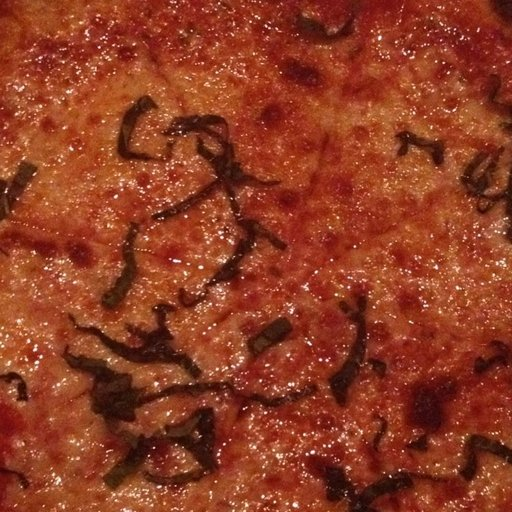

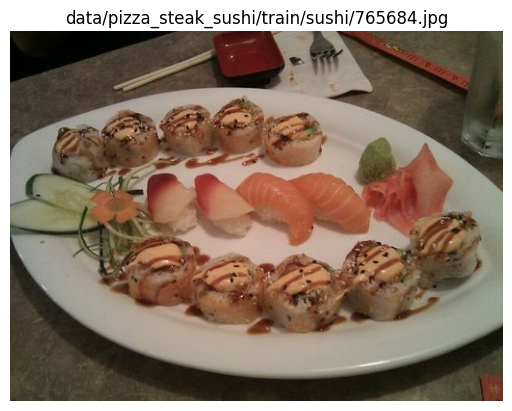

In [9]:
# 2. Image path list에서 랜덤하게 하나 뽑아서 보여주기

# PIL 사용해서 보여주기
def show_random_image_PIL(image_path_list):
    rand_path = random.sample(image_path_list, 1)[0]
    print(rand_path)
    with PIL.Image.open(rand_path) as image:
        image.show()

# matplotlib 사용해서 보여주기
def show_random_image_matplotlib(image_path_list):
    rand_path = random.sample(image_path_list, 1)[0]
    image = matplotlib.pyplot.imread(rand_path)
    matplotlib.pyplot.title(rand_path)
    matplotlib.pyplot.imshow(image)
    matplotlib.pyplot.axis(False)
    matplotlib.pyplot.show()

show_random_image_PIL(image_path_list)
show_random_image_matplotlib(image_path_list)

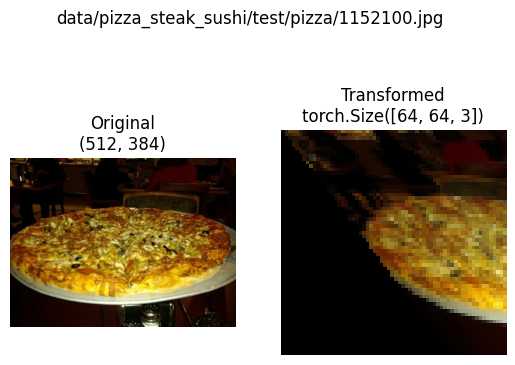

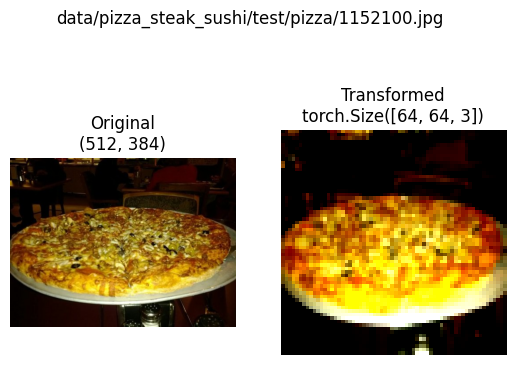

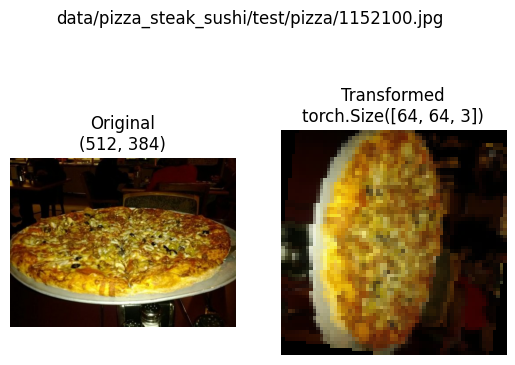

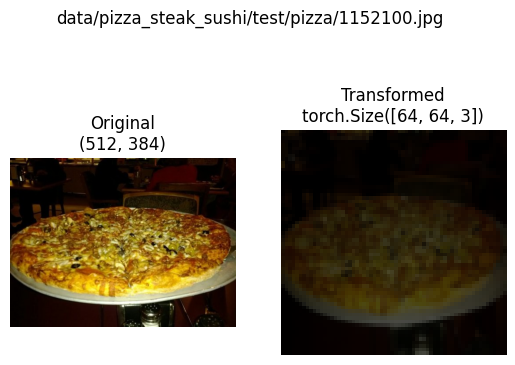

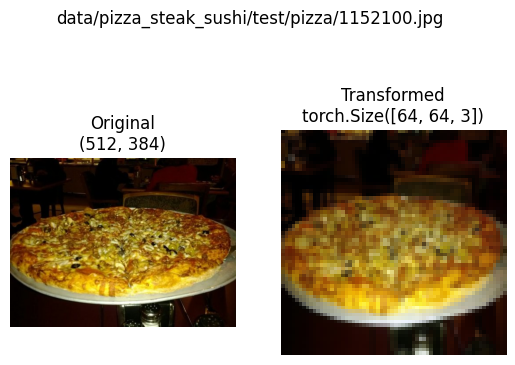

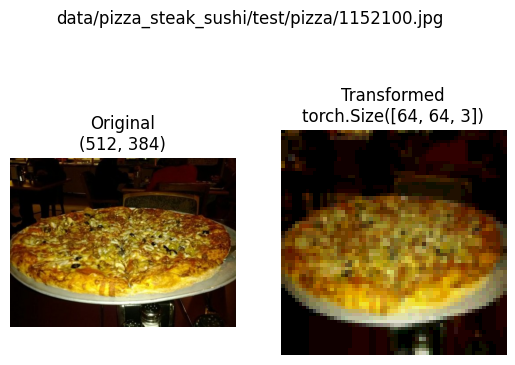

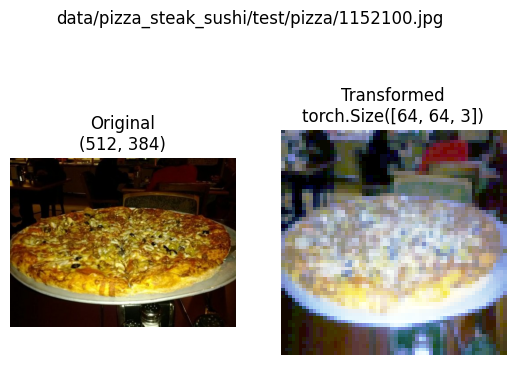

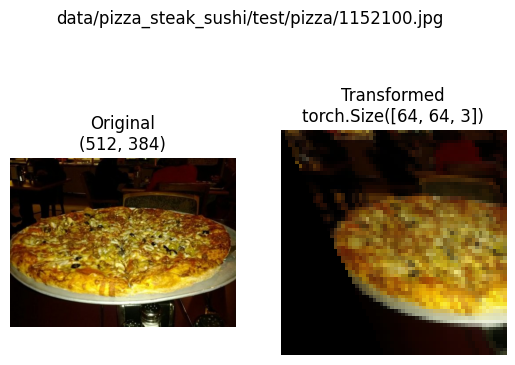

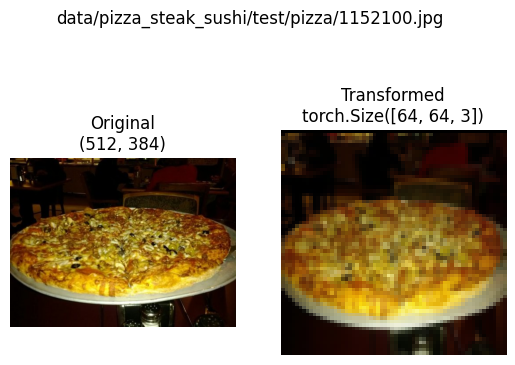

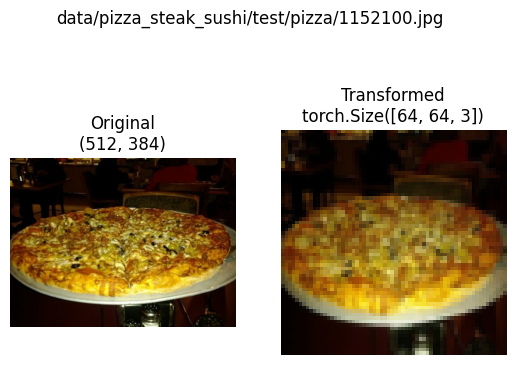

In [10]:
# 3. Image를 torchvision.transforms를 이용해 transform하고 화면에 보여주기

# 대표적인 transform
# - torchvision.transforms.Resize
# - torchvision.transforms.ToTensor
# - torchvision.transforms.TrivialAugmentWide
# - torchvision.transforms.RandomHorizontalFlip
# - torchvision.transforms.RandomVerticalFlip
# - torchvision.transforms.RandomRotation
# - torchvision.transforms.ColorJitter

transform_example = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),

    # 랜덤하게 Image에 여러 transform을 적용. 
    # 0-31로 정도를 조정 가능. 클수록 더 많이 변화
    # 이미지 크기는 변하지 않음
    torchvision.transforms.TrivialAugmentWide(31),

    # PIL Image나 ndarray를 tensor로 변환하고 value도 0.0~1.0으로 변환
    # PIL Image는 원래 0~255의 value를 가지고 있음
    torchvision.transforms.ToTensor(), 
])

def show_transformed_image(image_path, transform):
    with PIL.Image.open(image_path) as img:
        fig, ax = matplotlib.pyplot.subplots(1,2)
        ax[0].imshow(img)
        ax[0].set_title(f'Original\n{img.size}')
        ax[0].axis(False)

        tr_img = transform(img)
        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib 
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        tr_img = tr_img.permute(1, 2, 0)
        ax[1].imshow(tr_img)
        ax[1].set_title(f'Transformed\n{tr_img.shape}')
        ax[1].axis(False)

        fig.suptitle(f'{image_path}')
        matplotlib.pyplot.show()

image_path = random.choice(image_path_list)
for i in range(10):
    show_transformed_image(image_path, transform_example)

In [11]:
# 4. Train 할 Model 정의 (TinyVGG)

class TinyVGG(torch.nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, square_size, channel_cnt: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        output_field_size = square_size // 4 # <- 2*(2x2) max pool layers in model
        linear_input_size = hidden_units*output_field_size*output_field_size

        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels  = channel_cnt, 
                out_channels = hidden_units, 
                kernel_size  = 7, # how big is the square that's going over the image?

                stride  = 1,     # default

                padding = "same" # options = "valid" (no padding) or 
                                 # "same" (output has same shape as input) or 
                                 # int for specific number 
            ), 
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels  = hidden_units, 
                out_channels = hidden_units,
                kernel_size  = 5,
                stride       = 1,
                padding      = "same"
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels  = hidden_units, 
                out_channels = hidden_units,
                kernel_size  = 3,
                stride       = 1,
                padding      = "same"
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=2,
                stride=2       # default stride value is same as kernel_size
            )
        )
        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_units, hidden_units, kernel_size=7, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, kernel_size=5, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding="same"),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features  = linear_input_size,
                out_features = output_shape
            )
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


In [12]:
# 5. torchinfo를 사용해 Model의 memory footprint 편리하게 보기
#    - mult-add는 연산량을 말한다

model = TinyVGG(square_size = 64, channel_cnt=3, hidden_units = 32, output_shape = 3)
batch_size = 32
torchinfo.summary(model, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 32, 64, 64]          4,736
│    └─ReLU: 2-2                         [32, 32, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 32, 64, 64]          25,632
│    └─ReLU: 2-4                         [32, 32, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 32, 64, 64]          9,248
│    └─ReLU: 2-6                         [32, 32, 64, 64]          --
│    └─MaxPool2d: 2-7                    [32, 32, 32, 32]          --
├─Sequential: 1-2                        [32, 32, 16, 16]          --
│    └─Conv2d: 2-8                       [32, 32, 32, 32]          50,208
│    └─ReLU: 2-9                         [32, 32, 32, 32]          --
│    └─Conv2d: 2-10                      [32, 32, 32, 32]          25,6

In [13]:
# 6. Train/Test용 function 정의 + loss curve function 정의

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

import tqdm.auto

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm.auto.tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# Plot loss curves

def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    matplotlib.pyplot.figure(figsize=(15, 7))

    # Plot loss
    matplotlib.pyplot.subplot(1, 2, 1)
    matplotlib.pyplot.plot(epochs, loss, label='train_loss')
    matplotlib.pyplot.plot(epochs, test_loss, label='test_loss')
    matplotlib.pyplot.title('Loss')
    matplotlib.pyplot.xlabel('Epochs')
    matplotlib.pyplot.legend()

    # Plot accuracy
    matplotlib.pyplot.subplot(1, 2, 2)
    matplotlib.pyplot.plot(epochs, accuracy, label='train_accuracy')
    matplotlib.pyplot.plot(epochs, test_accuracy, label='test_accuracy')
    matplotlib.pyplot.title('Accuracy')
    matplotlib.pyplot.xlabel('Epochs')
    matplotlib.pyplot.legend()

def display_confusion_matrix(
        data_loader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        class_names: list[str],
        device: torch.device = device
    ):
    model.to(device)
    y_pred_list  = []
    y_label_list = []
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_pred_list.append(y_pred.cpu())
            y_label_list.append(y.cpu())
    
    y_pred_tensor = torch.cat(y_pred_list)
    y_label_tensor = torch.cat(y_label_list)

    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes = len(class_names), task='multiclass')
    confusion_matrix_tensor = confusion_matrix(preds=y_pred_tensor, target=y_label_tensor)

    fig, ax = mlxtend.plotting.plot_confusion_matrix(
        conf_mat=confusion_matrix_tensor.numpy(),
        class_names = class_names,
        figsize=(10,7)
    )
    matplotlib.pyplot.show()

len(dataset_imgf_train) = 225
len(dataset_imgf_test) = 75


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.2978 | test_loss: 1.1025 | test_acc: 0.3600
Epoch: 2 | train_loss: 1.1000 | train_acc: 0.3467 | test_loss: 1.1049 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0964 | train_acc: 0.3778 | test_loss: 1.0773 | test_acc: 0.3867
Epoch: 4 | train_loss: 0.9932 | train_acc: 0.4756 | test_loss: 1.0131 | test_acc: 0.4400
Epoch: 5 | train_loss: 0.8897 | train_acc: 0.5556 | test_loss: 1.0487 | test_acc: 0.4533
Epoch: 6 | train_loss: 0.8762 | train_acc: 0.6400 | test_loss: 0.9797 | test_acc: 0.4533
Epoch: 7 | train_loss: 0.7851 | train_acc: 0.6622 | test_loss: 1.0937 | test_acc: 0.4400
Epoch: 8 | train_loss: 0.7489 | train_acc: 0.6844 | test_loss: 1.0294 | test_acc: 0.4800
Epoch: 9 | train_loss: 0.7352 | train_acc: 0.6667 | test_loss: 1.1032 | test_acc: 0.4267
Epoch: 10 | train_loss: 0.6995 | train_acc: 0.7289 | test_loss: 1.0220 | test_acc: 0.4400
Epoch: 11 | train_loss: 0.6323 | train_acc: 0.7556 | test_loss: 1.1485 | test_acc: 0.4400
Epoch: 12 | train_l

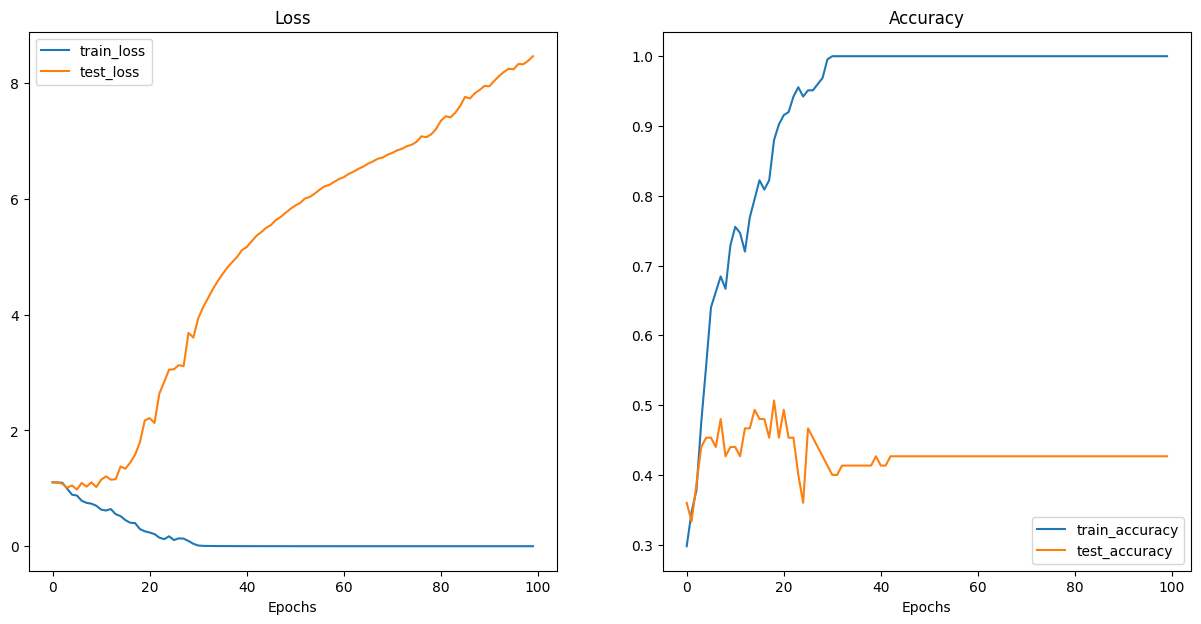

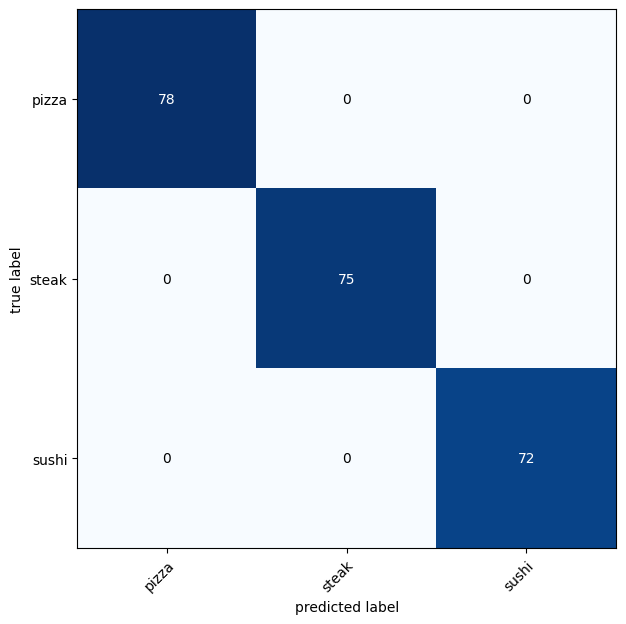

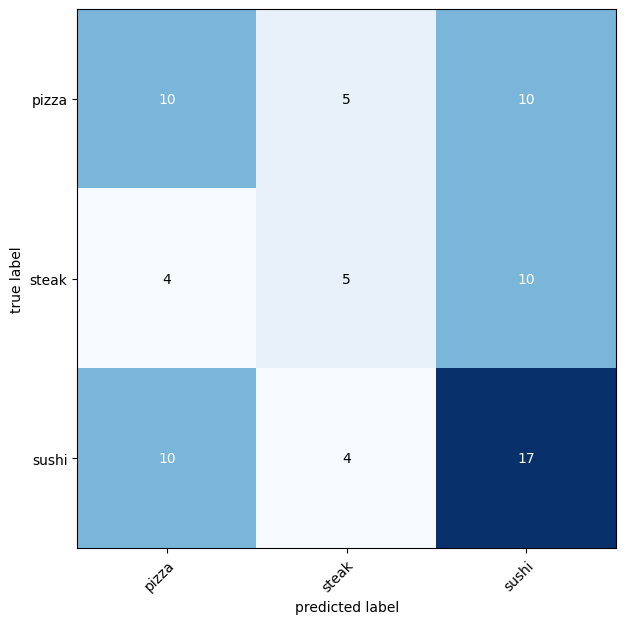

time elapsed = 79.67557974997908


In [14]:
# 7. ImageFolder를 이용해 DataSet을 만들고 이것으로 training
#    - 매우 명백하게 overfitting이 발생함을 확인

def training_template_imagefolder(transform, square_size, batch_size, num_epochs):
    train_dir = 'data/pizza_steak_sushi/train'
    test_dir = 'data/pizza_steak_sushi/test'

    # 1. Load and transform data
    dataset_imgf_train = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
    dataset_imgf_test = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

    print(f'len(dataset_imgf_train) = {len(dataset_imgf_train)}')
    print(f'len(dataset_imgf_test) = {len(dataset_imgf_test)}')

    dataldr_imgf_train = torch.utils.data.DataLoader(dataset_imgf_train, batch_size=batch_size, shuffle=True)
    dataldr_imgf_test = torch.utils.data.DataLoader(dataset_imgf_test, batch_size=batch_size, shuffle=False)

    model_imgf = TinyVGG(
        square_size = square_size, channel_cnt=3, hidden_units = 32, output_shape = 3).to(device)

    loss_func_imgf = torch.nn.CrossEntropyLoss()
    optimizer_imgf = torch.optim.Adam(model_imgf.parameters(), lr=0.0001)

    t_beg = timeit.default_timer()

    results_imgf = train(
                    model = model_imgf, 
                    train_dataloader = dataldr_imgf_train, 
                    test_dataloader = dataldr_imgf_test, 
                    optimizer = optimizer_imgf, 
                    loss_fn = loss_func_imgf, 
                    epochs = num_epochs
                )

    t_end = timeit.default_timer()

    plot_loss_curves(results_imgf)
    display_confusion_matrix(dataldr_imgf_train, model_imgf, dataset_imgf_train.classes)
    display_confusion_matrix(dataldr_imgf_test, model_imgf, dataset_imgf_train.classes)
    print(f'time elapsed = {t_end - t_beg}')


# 이미지를 64x64로 resize하고 tensor로 변환
square_size = 64
simple_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize((square_size, square_size)),
    torchvision.transforms.ToTensor(),
])

training_template_imagefolder(
    transform = simple_transform, 
    square_size = square_size,
    batch_size = 5,
    num_epochs = 100
)

len(dataset_imgf_train) = 225
len(dataset_imgf_test) = 75


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1022 | train_acc: 0.2622 | test_loss: 1.0989 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0987 | train_acc: 0.3200 | test_loss: 1.0991 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0966 | train_acc: 0.3467 | test_loss: 1.0967 | test_acc: 0.3067
Epoch: 4 | train_loss: 1.0669 | train_acc: 0.4400 | test_loss: 1.0351 | test_acc: 0.4400
Epoch: 5 | train_loss: 0.9839 | train_acc: 0.5156 | test_loss: 1.0918 | test_acc: 0.4133
Epoch: 6 | train_loss: 1.0209 | train_acc: 0.5244 | test_loss: 1.1116 | test_acc: 0.3600
Epoch: 7 | train_loss: 0.9952 | train_acc: 0.5156 | test_loss: 1.0817 | test_acc: 0.3600
Epoch: 8 | train_loss: 0.9513 | train_acc: 0.5644 | test_loss: 1.1521 | test_acc: 0.4000
Epoch: 9 | train_loss: 0.9533 | train_acc: 0.5511 | test_loss: 1.0463 | test_acc: 0.4400
Epoch: 10 | train_loss: 0.8790 | train_acc: 0.5733 | test_loss: 1.1018 | test_acc: 0.4267
Epoch: 11 | train_loss: 0.8910 | train_acc: 0.5644 | test_loss: 1.1266 | test_acc: 0.4133
Epoch: 12 | train_l

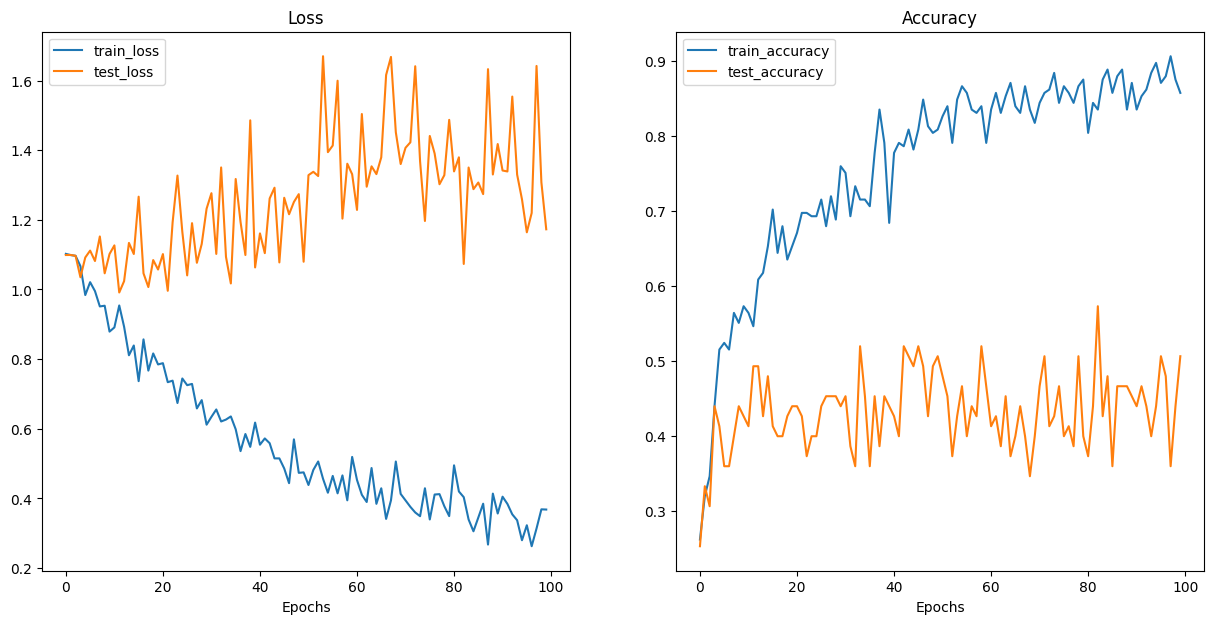

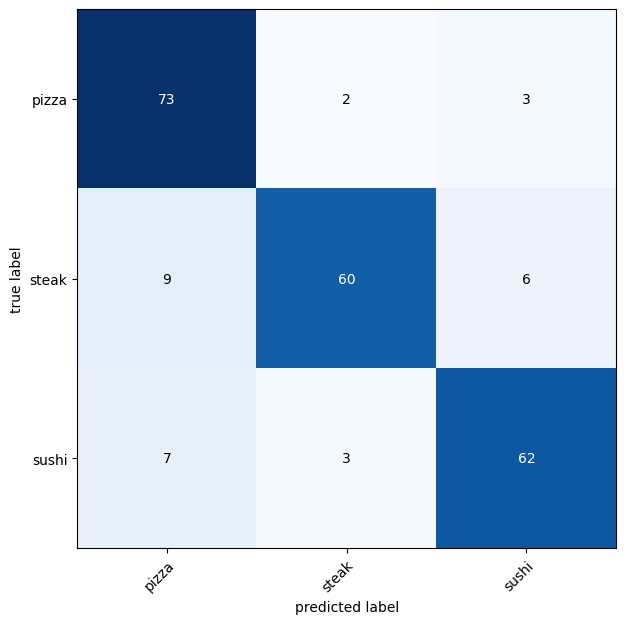

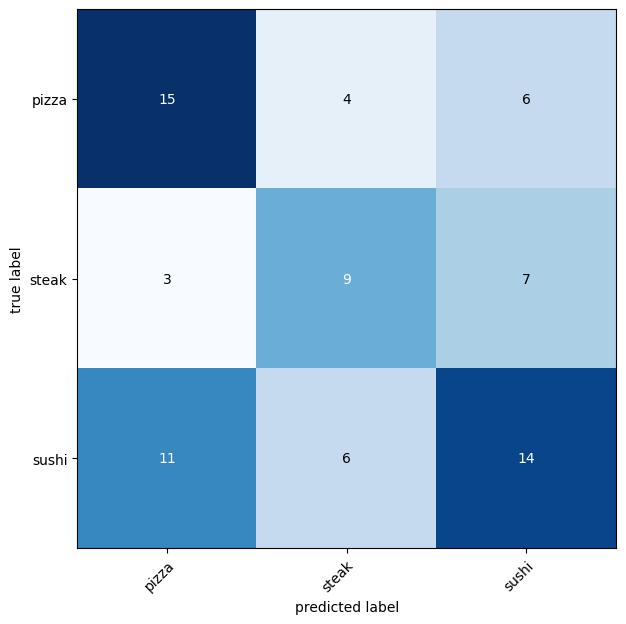

time elapsed = 85.73632612699294


In [15]:
# ImageFolder를 이용해 DataSet을 만들되 transform에 TrivialAugmentWide를 적용
#    - 여전히 결과는 좋지 않지만 overfitting은 확실히 덜해졌다
#    - 그러나 loss 역시 전에 비해 더 안좋아짐

transform_taw = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize((square_size, square_size)),
    torchvision.transforms.TrivialAugmentWide(2),
    torchvision.transforms.ToTensor(),
])

training_template_imagefolder(
    transform = transform_taw, 
    square_size = square_size,
    batch_size = 5,
    num_epochs = 100
)

len(dataset_imgf_train) = 225
len(dataset_imgf_test) = 75


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1008 | train_acc: 0.2933 | test_loss: 1.0998 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0988 | train_acc: 0.3422 | test_loss: 1.1012 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.1007 | train_acc: 0.3600 | test_loss: 1.0940 | test_acc: 0.4267
Epoch: 4 | train_loss: 1.0944 | train_acc: 0.3733 | test_loss: 1.0833 | test_acc: 0.4000
Epoch: 5 | train_loss: 1.0904 | train_acc: 0.4044 | test_loss: 1.0802 | test_acc: 0.3733
Epoch: 6 | train_loss: 1.0545 | train_acc: 0.4222 | test_loss: 1.0574 | test_acc: 0.4000
Epoch: 7 | train_loss: 0.9866 | train_acc: 0.4667 | test_loss: 1.0132 | test_acc: 0.5200
Epoch: 8 | train_loss: 0.9800 | train_acc: 0.5067 | test_loss: 1.0357 | test_acc: 0.4667
Epoch: 9 | train_loss: 0.9476 | train_acc: 0.5556 | test_loss: 1.0380 | test_acc: 0.4800
Epoch: 10 | train_loss: 0.9389 | train_acc: 0.5556 | test_loss: 0.9561 | test_acc: 0.5067
Epoch: 11 | train_loss: 0.9328 | train_acc: 0.5556 | test_loss: 1.0581 | test_acc: 0.4133
Epoch: 12 | train_l

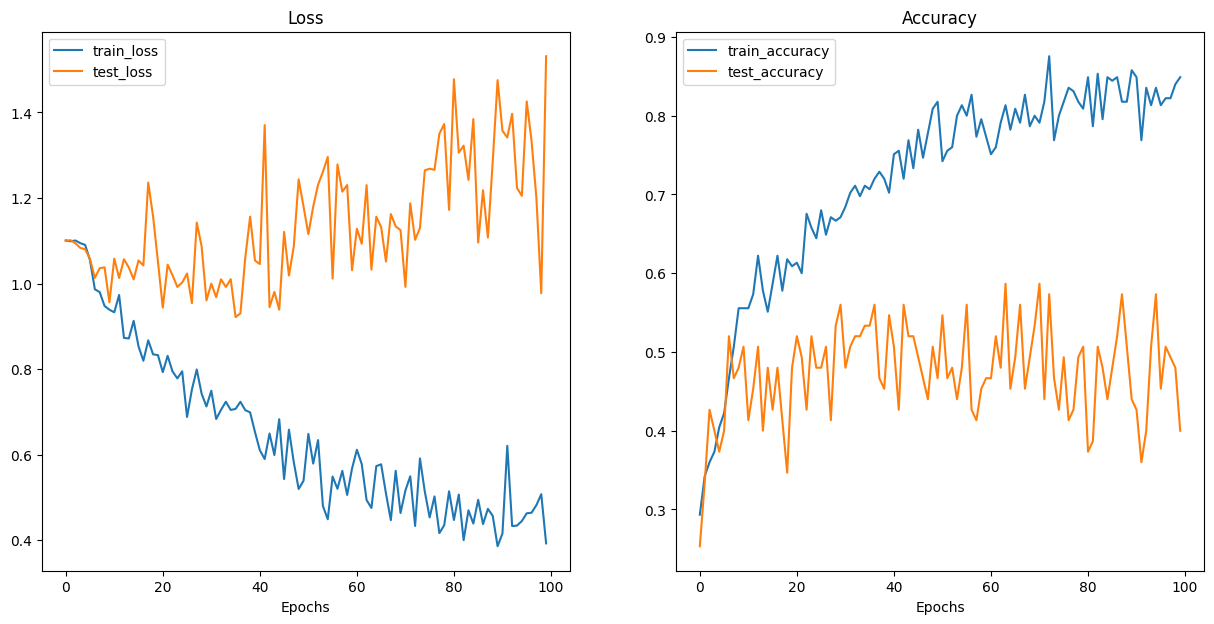

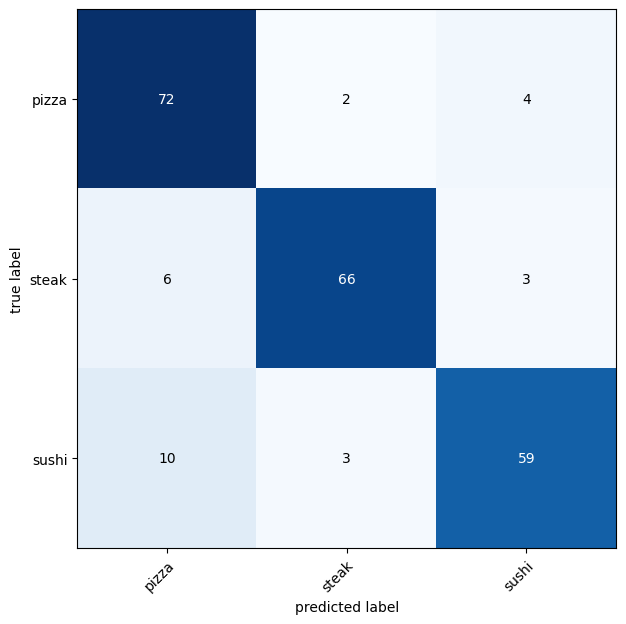

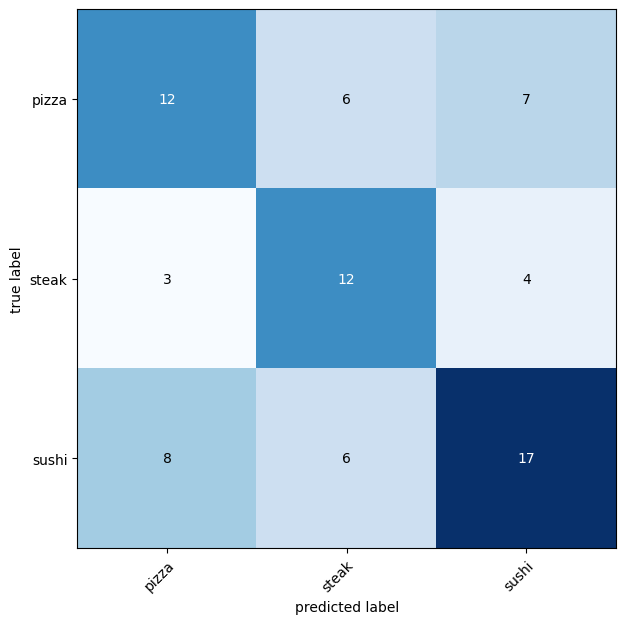

time elapsed = 86.45762892300263


In [16]:
# TrivialAugmentWide 수치를 좀 더 늘리면 overfitting 되는 정도가 좀 더 줄어든다
# 하지만 test_loss, test_accuracy는 별 차이 없음

transform_taw = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize((square_size, square_size)),
    torchvision.transforms.TrivialAugmentWide(31),
    torchvision.transforms.ToTensor(),
])

training_template_imagefolder(
    transform = transform_taw, 
    square_size = square_size,
    batch_size = 5,
    num_epochs = 100
)

In [17]:
# 8. Custom Dataset을 만든다. 여러가지 transform을 적용한걸 원본과 **함께** 추가한다
#    - 여전히 overfitting이 발생한다. 근본적으로 데이터가 적어서 어쩔 수 없는 것 같다. 아예 모델을 더 좋은걸 쓰는게 낫지 않을까
#    - 그래도 data를 전부다 preload하기 때문에 ImageFolder때 보다 데이터가 많음에도 속도가 더 빠르다. 이것때문에라도 CustomDataSet을 사용할 필요가 있다

# 1. Subclass torch.utils.data.Dataset
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, target_dir: str, img_width:int, img_height:int, transform_list:list[torchvision.transforms.Compose]) -> None:
        self.target_dir = target_dir
        self.transform_list = transform_list

        self.base_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((img_width, img_height)),
            torchvision.transforms.ToTensor(),
        ])

        self.classes = []
        self.class_to_idx = {}
        self.img_list = []

        img_path_list = []
        class_dirs = os.listdir(self.target_dir)
        class_dirs.sort()
        for class_idx, class_name in enumerate(class_dirs):
            cur_abspath = os.path.abspath(os.path.join(self.target_dir, class_name))
            if not os.path.isdir(cur_abspath):
                continue

            self.classes.append(class_name)
            self.class_to_idx[class_name] = class_idx

            for img_name in os.listdir(cur_abspath):
                img_abspath = os.path.abspath(os.path.join(cur_abspath, img_name))
                if not os.path.isfile(img_abspath):
                    continue
                if not img_abspath.endswith('.jpg'):
                    continue
                img_path_list.append((img_abspath, class_idx))
        
        print(f'len(img_path_list) = {len(img_path_list)}')
        
        for img_abspath, class_idx in img_path_list:
            with PIL.Image.open(img_abspath) as img:
                img_base = self.base_transform(img)

                self.img_list.append((img_base, class_idx))

                for transform in self.transform_list:
                    self.img_list.append((transform(img), class_idx))

        random.shuffle(self.img_list)
        print(f'len(self.img_list) = {len(self.img_list)}')
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        return len(self.img_list)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        return self.img_list[index]        

In [25]:
def training_template_customdataset(transform_list, square_size, batch_size, num_epochs):
    train_dir = 'data/pizza_steak_sushi/train'
    test_dir = 'data/pizza_steak_sushi/test'

    # 1. Load and transform data
    dataset_custom_train = CustomDataSet(
        target_dir=train_dir, 
        img_width=square_size, 
        img_height=square_size, 
        transform_list=transform_list
    )
    dataset_custom_test = CustomDataSet(
        target_dir=test_dir, 
        img_width=square_size, 
        img_height=square_size, 
        transform_list=[]
    )

    print(f'len(dataset_imgf_train) = {len(dataset_custom_train)}')
    print(f'len(dataset_imgf_test) = {len(dataset_custom_test)}')

    dataldr_custom_train = torch.utils.data.DataLoader(dataset_custom_train, batch_size=batch_size, shuffle=True)
    dataldr_custom_test = torch.utils.data.DataLoader(dataset_custom_test, batch_size=batch_size, shuffle=False)

    model_imgf = TinyVGG(
        square_size = square_size, channel_cnt=3, hidden_units = 32, output_shape = 3).to(device)

    loss_func_imgf = torch.nn.CrossEntropyLoss()
    optimizer_imgf = torch.optim.Adam(model_imgf.parameters(), lr=0.001)

    t_beg = timeit.default_timer()

    results_imgf = train(
                    model = model_imgf, 
                    train_dataloader = dataldr_custom_train, 
                    test_dataloader = dataldr_custom_test, 
                    optimizer = optimizer_imgf, 
                    loss_fn = loss_func_imgf, 
                    epochs = num_epochs
                )

    t_end = timeit.default_timer()

    plot_loss_curves(results_imgf)
    display_confusion_matrix(dataldr_custom_train, model_imgf, dataset_custom_train.classes)
    display_confusion_matrix(dataldr_custom_test, model_imgf, dataset_custom_train.classes)
    print(f'time elapsed = {t_end - t_beg}')

len(img_path_list) = 225
len(self.img_list) = 1800
len(img_path_list) = 75
len(self.img_list) = 75
len(dataset_imgf_train) = 1800
len(dataset_imgf_test) = 75


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0948 | train_acc: 0.3821 | test_loss: 1.1139 | test_acc: 0.2775
Epoch: 2 | train_loss: 1.0052 | train_acc: 0.4572 | test_loss: 0.9788 | test_acc: 0.4223
Epoch: 3 | train_loss: 0.8830 | train_acc: 0.5877 | test_loss: 0.9797 | test_acc: 0.3731
Epoch: 4 | train_loss: 0.8458 | train_acc: 0.6031 | test_loss: 1.0284 | test_acc: 0.4129
Epoch: 5 | train_loss: 0.8193 | train_acc: 0.6151 | test_loss: 0.9755 | test_acc: 0.4536
Epoch: 6 | train_loss: 0.7662 | train_acc: 0.6436 | test_loss: 0.9296 | test_acc: 0.5038
Epoch: 7 | train_loss: 0.7431 | train_acc: 0.6617 | test_loss: 1.1746 | test_acc: 0.4432
Epoch: 8 | train_loss: 0.7587 | train_acc: 0.6579 | test_loss: 0.9799 | test_acc: 0.4953
Epoch: 9 | train_loss: 0.6941 | train_acc: 0.6848 | test_loss: 1.0299 | test_acc: 0.5142
Epoch: 10 | train_loss: 0.6895 | train_acc: 0.7029 | test_loss: 1.0814 | test_acc: 0.4640
Epoch: 11 | train_loss: 0.6018 | train_acc: 0.7544 | test_loss: 1.1850 | test_acc: 0.4640
Epoch: 12 | train_l

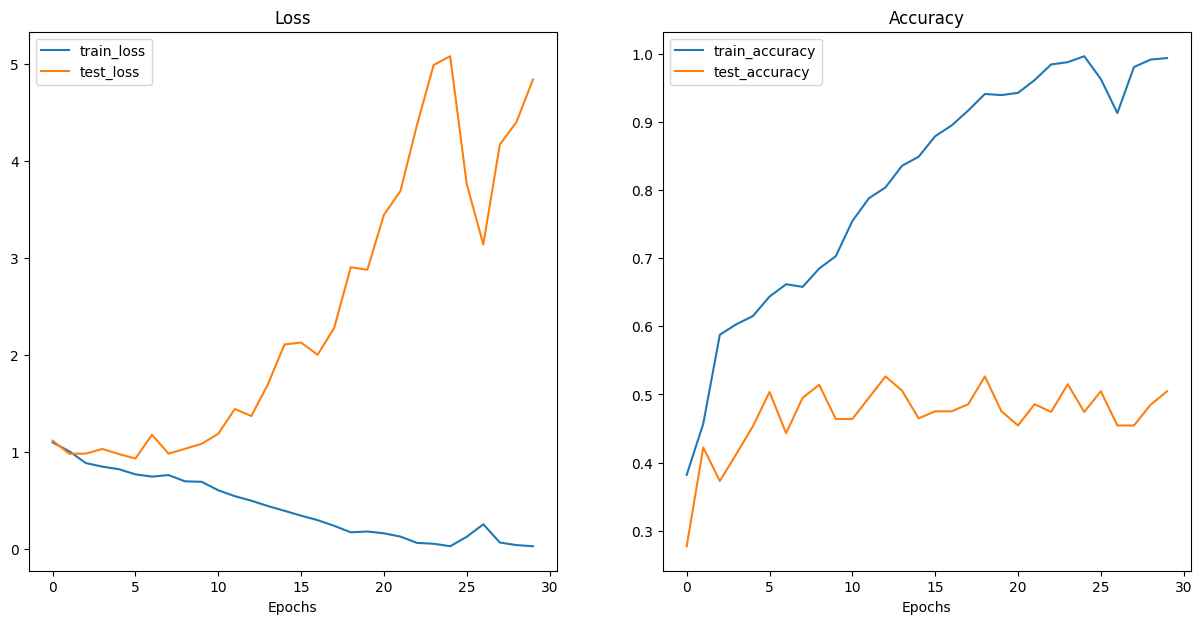

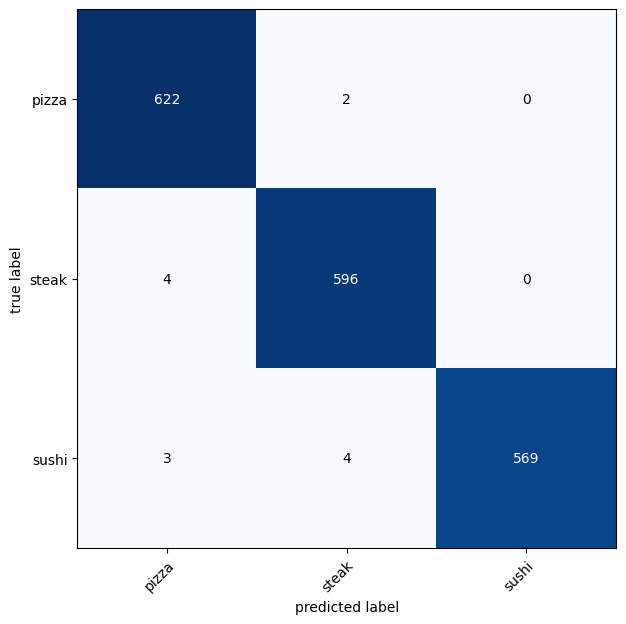

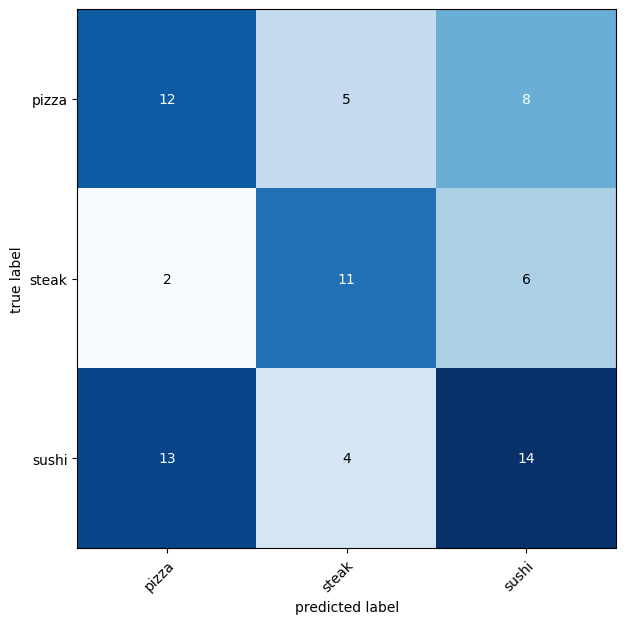

time elapsed = 89.04216569900746


In [26]:
square_size = 128

transform_list = [
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.RandomHorizontalFlip(p=1.0),
        torchvision.transforms.ToTensor(),
    ]),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.RandomVerticalFlip(p=1.0),
        torchvision.transforms.ToTensor(),
    ]),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.RandomRotation(degrees=(90, 90)),
        torchvision.transforms.ToTensor(),
    ]),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.RandomRotation(degrees=(180, 180)),
        torchvision.transforms.ToTensor(),
    ]),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.RandomRotation(degrees=(270, 270)),
        torchvision.transforms.ToTensor(),
    ]),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.ColorJitter(0.1,0.1,0.1,0.1),
        torchvision.transforms.ToTensor(),
    ]),
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((square_size,square_size)),
        torchvision.transforms.TrivialAugmentWide(31),
        torchvision.transforms.ToTensor(),
    ]),
]

batch_size = 32
num_epochs = 30
training_template_customdataset(transform_list, square_size, batch_size, num_epochs)